In [1]:
import torch
import numpy as np
import pandas as pd
import sys
import os
import torchvision
import Inception
import BasicCNN
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from PIL import Image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Running GPU.


In [2]:
def test_pretrained_model(data_path, model, load_model_path, batch_size=1):
    load_model_path = "\\".join((r"C:\Users\marcv\Desktop\Lime Results\Trained_models",load_model_path))
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    batch_size = batch_size
    
    
    path = "\\".join((r"C:\Users\marcv\Desktop\Lime Results\256_Train_upsample_only",data_path))
    model_type = model
    
    if model == "inception":
        model = Inception.inception_v3()
    elif model == "basic":
        model = BasicCNN.Net_256()
        
    
    def test_loader():
        data_path = path
        if model_type == "inception":            
            test_dataset = torchvision.datasets.ImageFolder(
                root=data_path,
                transform=torchvision.transforms.Compose([
                    #torchvision.transforms.RandomRotation(180),
                    #torchvision.transforms.RandomHorizontalFlip(p=0.5),
                    torchvision.transforms.Pad((21, 22, 22, 21)),
                    torchvision.transforms.ToTensor()])
                )
        if model_type == "basic":            
            test_dataset = torchvision.datasets.ImageFolder(
                root=data_path,
                transform=torchvision.transforms.Compose([
                    #torchvision.transforms.RandomRotation(180),
                    #torchvision.transforms.RandomHorizontalFlip(p=0.5),
                    #torchvision.transforms.Pad((21, 22, 22, 21)),
                    torchvision.transforms.ToTensor()])
                )
        test_loader = torch.utils.data.DataLoader(
            test_dataset,
            batch_size=batch_size,
            num_workers=0,
            shuffle=False
        )
        
        return test_dataset, test_loader
    net = model.to(device)
    
    
    cp = torch.load(load_model_path,map_location='cuda:0')
    
    cp_new_dict = dict()
    for key in cp['state_dict']:
        newkey=key[7:]
        cp_new_dict[newkey] = cp['state_dict'][key]
    net.load_state_dict(cp_new_dict)



    Num_test_pics = len(test_loader())
    net.eval()
    prob_list = list()
    truth_list = list()
    for i, (test_images, test_labels) in enumerate(test_loader()[1],0):
        test_dataset, loader = test_loader()
        test_images = test_images.to('cuda:0')
        #test_images = test_images.to(device)
        #test_labels = test_labels.to(device)
        out = net(test_images).detach().cpu()
        prob = torch.sigmoid(out)
        pred = (prob>0.5).float().numpy()
        truth = test_labels.numpy()[0]
        #truth = test_labels.detach().cpu().numpy()[0]
        prob_list.append(prob.numpy()[0])
        truth_list.append(truth)
        
    return test_dataset.imgs, prob_list, truth_list

## Load a model

In [3]:
def load_model_pred(data_path, model, load_model_path):    
    fnames, pred_values, labels = test_pretrained_model(data_path=data_path, model=model,  load_model_path=load_model_path)
    for idx, t in enumerate(fnames):
        fnames[idx] = t[0]
    df = pd.DataFrame(list(zip(fnames, pred_values, labels)),columns=['img_name','pred', 'truth'])

    positives = df[df['truth']==1]
    negatives = df[df['truth']==0]



    TP_df = positives[positives['pred']>0.5]
    TP_df = TP_df.sort_values(by=['pred'])

    FN_df = positives[positives['pred']<0.5]
    FN_df = FN_df.sort_values(by=['pred'])


    TN_df = negatives[negatives['pred']<0.5]
    TN_df = TN_df.sort_values(by=['pred'], ascending=False)

    FP_df = negatives[negatives['pred']>0.5]
    FP_df = FP_df.sort_values(by=['pred'], ascending=False)



    ########################################


    temp = list(df['img_name'])
    for idx, val in enumerate(temp):
        temp[idx] = val.split("\\")[-1]

    df['img_name'] = temp


    temp = list(df['pred'])
    for idx, val in enumerate(temp):
        temp[idx] = val[0]

    df['pred'] = temp

    ##########################################

    temp = list(FN_df['img_name'])
    for idx, val in enumerate(temp):
        temp[idx] = val.split("\\")[-1]

    FN_df['img_name'] = temp


    temp = list(FN_df['pred'])
    for idx, val in enumerate(temp):
        temp[idx] = val[0]

    FN_df['pred'] = temp


    ###########################################


    temp = list(TP_df['img_name'])
    for idx, val in enumerate(temp):
        temp[idx] = val.split("\\")[-1]

    TP_df['img_name'] = temp


    temp = list(TP_df['pred'])
    for idx, val in enumerate(temp):
        temp[idx] = val[0]

    TP_df['pred'] = temp


    ###########################################
    return df, FN_df, TP_df

## Create Histplots

In [4]:
matplotlib.rcParams.update({'font.size': 14})
def plot_hist(data_path, model, load_model_path1, load_model_path2):
    
    global data_sti
    global model_name
    global name1
    global name2
    global df
    global FN_df
    global TP_df
    global df_enh
    global FN_df_enh
    global TP_df_enh
    
    try:
        name1, name2, data_sti
    except:
        name1="None"
        name2="None"
        data_sti="None"
    
   
    
    
    #If it is a different model or a different control instance, get control data    
    if not name1 ==  load_model_path1.split("\\")[-1].split(".")[0] or not model_name == model or not data_sti == data_path:
        print("Loading Control Predictions")
        df, FN_df, TP_df = load_model_pred(data_path=data_path, model=model,  load_model_path=load_model_path1)
    else:
        print("Using cached Control Predictions")
    name1 = load_model_path1.split("\\")[-1].split(".")[0]
        
    #If it is a different model or a different enhanced instance, get enhanced data    
    if not name2 == load_model_path2.split("\\")[-1].split(".")[0] or not model_name == model or not data_sti == data_path:
        print("Loading Enhanced Predictions")
        df_enh, FN_df_enh, TP_df_enh = load_model_pred(data_path=data_path, model=model,  load_model_path=load_model_path2)
    else:
        print("Using cached Enhanced Predictions")

    model_name = model
    name2 = load_model_path2.split("\\")[-1].split(".")[0]

        
    fig, ax = plt.subplots(3, 2, sharey='row', figsize=(20, 18))

    df.hist(column='pred', ax=ax[0,0], alpha=0.7, color='red', grid=False, edgecolor='black', linewidth=1.2)
    df_enh.hist(column='pred', ax=ax[0,1], alpha=0.7, color='deepskyblue', grid=False, edgecolor='black', linewidth=1.2)
    ax[0,0].set_title('Prediction distribution ' + name1)
    ax[0,1].set_title('Prediction distribution ' + name2)
    ax[0,0].set_xlim([-0.025, 1.025])
    ax[0,1].set_xlim([-0.025, 1.025])


    FN_df.hist(column='pred', ax=ax[1,0], alpha=0.7, color='red', grid=False, edgecolor='black', linewidth=1.2)
    FN_df_enh.hist(column='pred', ax=ax[1,1], alpha=0.7, color='deepskyblue', grid=False, edgecolor='black', linewidth=1.2)
    ax[1,0].set_title('FN distribution ' + name1)
    ax[1,1].set_title('FN distribution ' + name2)
    ax[1,0].set_xlim([-0.025, 0.525])
    ax[1,1].set_xlim([-0.025, 0.525])


    TP_df.hist(column='pred', ax=ax[2,0], alpha=0.7, color='red', grid=False, edgecolor='black', linewidth=1.2)
    TP_df_enh.hist(column='pred', ax=ax[2,1], alpha=0.7, color='deepskyblue', grid=False, edgecolor='black', linewidth=1.2)
    ax[2,0].set_title('TP distribution ' + name1)
    ax[2,1].set_title('TP distribution ' + name2)
    ax[2,0].set_xlim([0.475, 1.025])
    ax[2,1].set_xlim([0.475, 1.025])
    
    data_sti = data_path
    
    plt.tight_layout()
    plt.savefig(data_path.split("\\")[-1] + " " + name1 + "_" + name2)
    plt.show()


Loading Control Predictions
Loading Enhanced Predictions


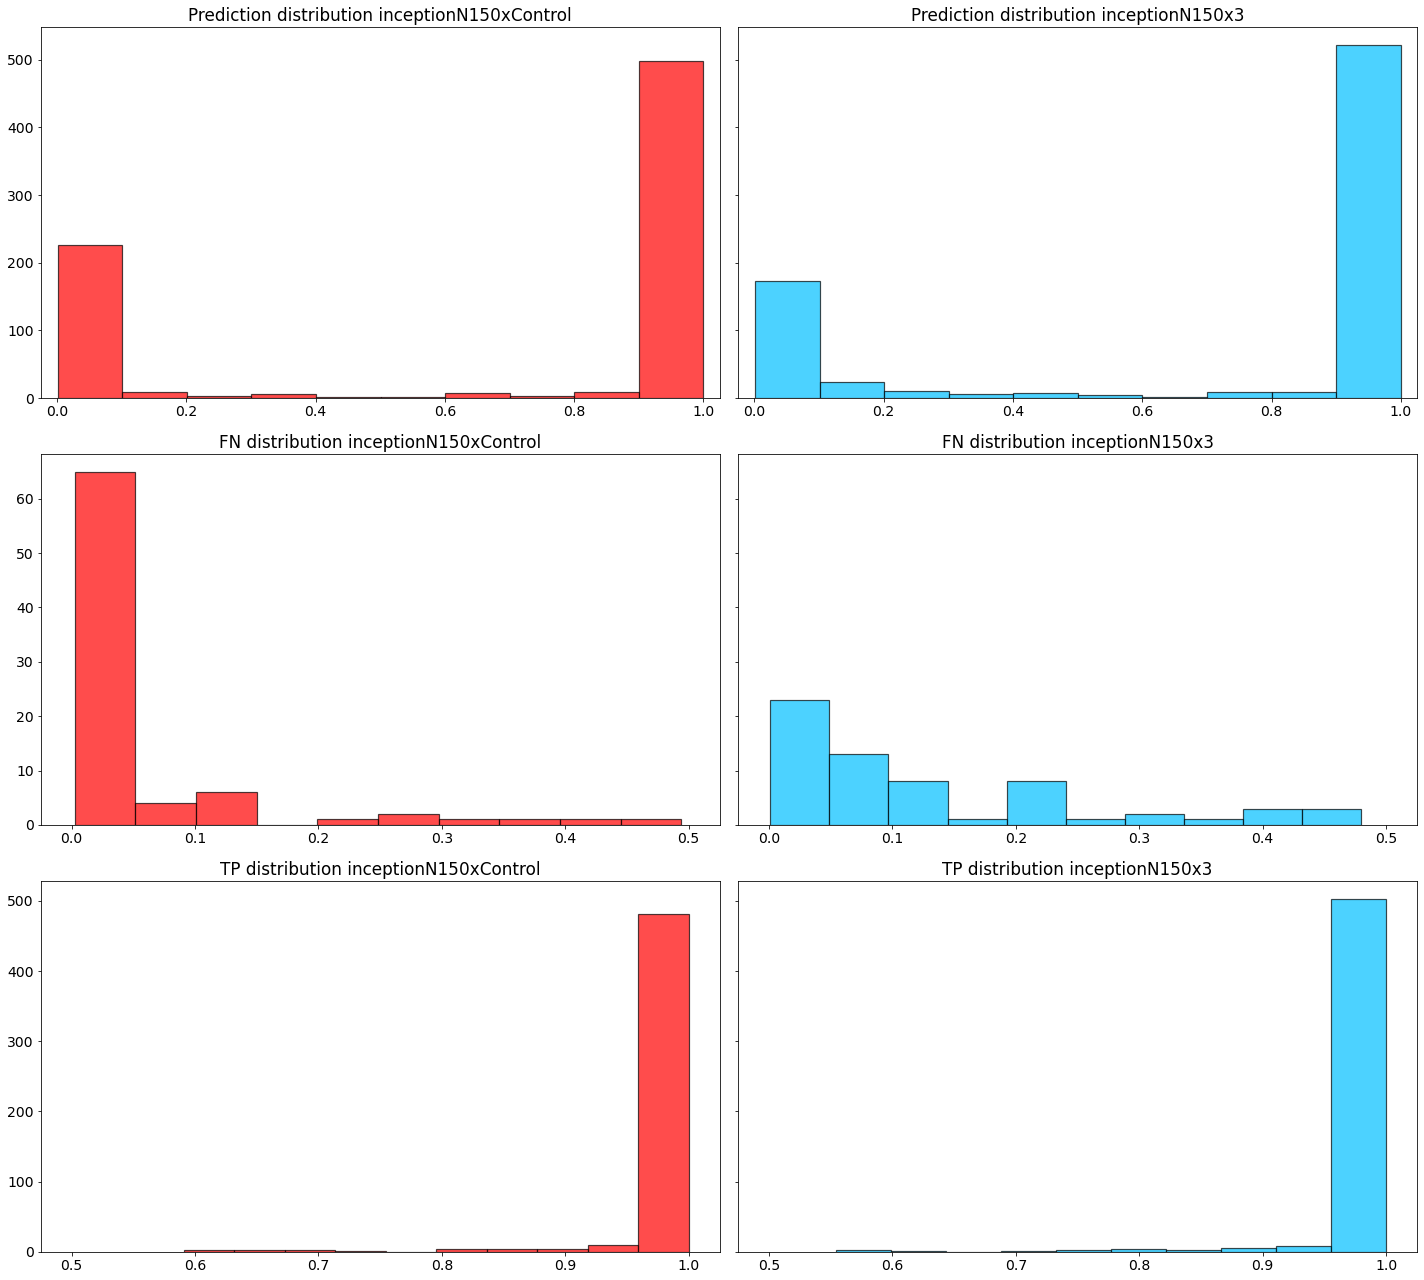

In [5]:
plot_hist(data_path='Test', model='inception',  load_model_path1=r"\Selected\N150\inceptionN150xControl.pth.tar", load_model_path2=r"\Selected\N150\inceptionN150x3.pth.tar")

First done
Second done
Third done


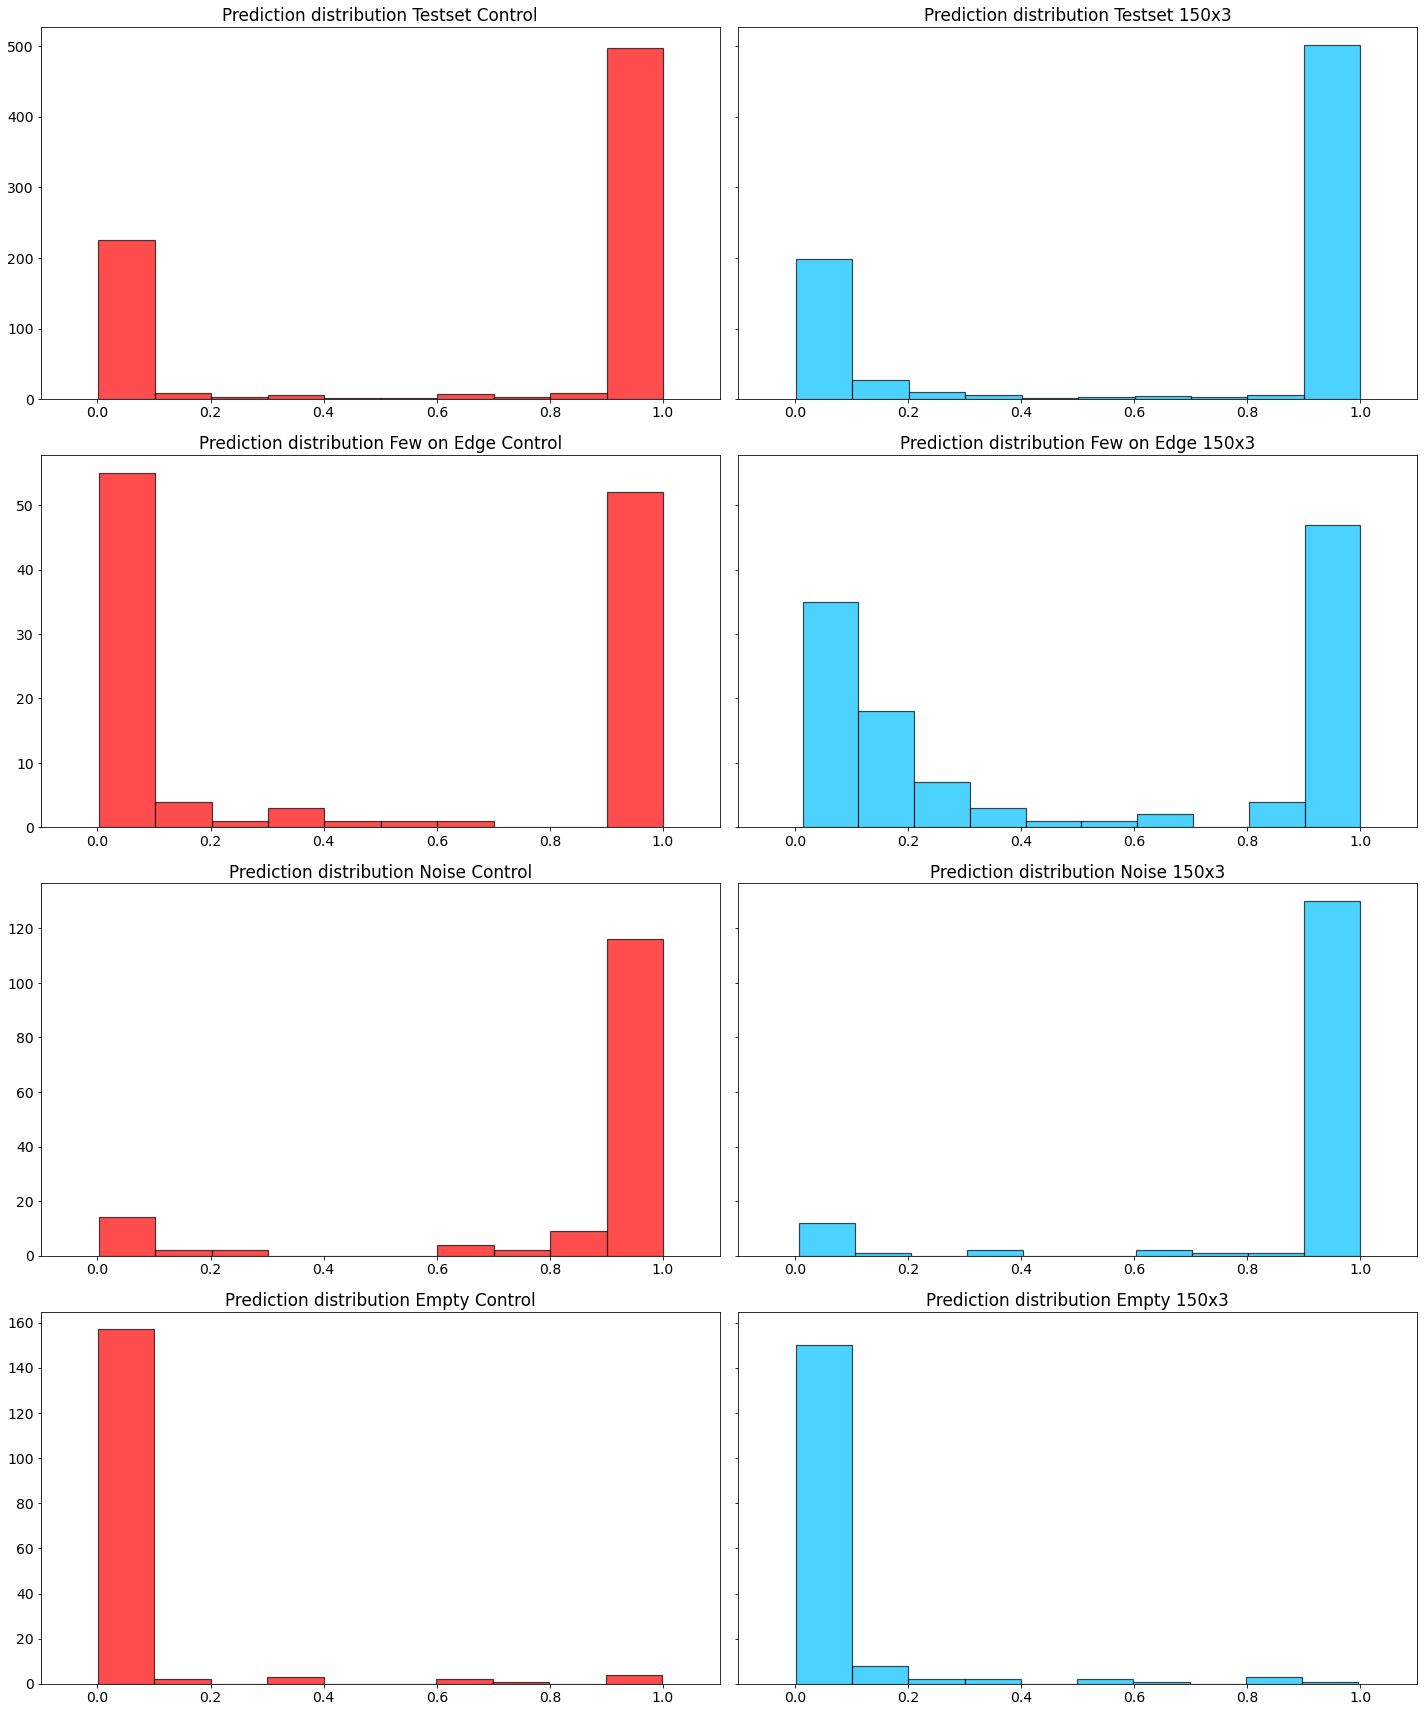

In [17]:
#If it is a different model or a different control instance, get control data    

model1 = r"\Selected\N150\inceptionN150xControl.pth.tar"
model2 = r"\Mix\inceptionMix150x4.pth.tar"
    
fig, ax = plt.subplots(4, 2, sharey='row', figsize=(20, 24))



df, FN_df, TP_df = load_model_pred(data_path="Test", model="inception",  load_model_path=model1)
df_enh, FN_df_enh, TP_df_enh = load_model_pred(data_path="Test", model="inception",  load_model_path=model2)

df.hist(column='pred', ax=ax[0,0], alpha=0.7, color='red', grid=False, edgecolor='black', linewidth=1.2)
df_enh.hist(column='pred', ax=ax[0,1], alpha=0.7, color='deepskyblue', grid=False, edgecolor='black', linewidth=1.2)
ax[0,0].set_title('Prediction distribution Testset Control' )
ax[0,1].set_title('Prediction distribution Testset 150x3')
ax[0,0].set_xlim([-0.1, 1.1])
ax[0,1].set_xlim([-0.1, 1.1])

print("First done")

#########################################################################################################################

df, FN_df, TP_df = load_model_pred(data_path="Test_types\\Few on Edge", model="inception",  load_model_path=model1)
df_enh, FN_df_enh, TP_df_enh = load_model_pred(data_path="Test_types\\Few on Edge", model="inception",  load_model_path=model2)

df.hist(column='pred', ax=ax[1,0], alpha=0.7, color='red', grid=False, edgecolor='black', linewidth=1.2)
df_enh.hist(column='pred', ax=ax[1,1], alpha=0.7, color='deepskyblue', grid=False, edgecolor='black', linewidth=1.2)
ax[1,0].set_title('Prediction distribution Few on Edge Control' )
ax[1,1].set_title('Prediction distribution Few on Edge 150x3')
ax[1,0].set_xlim([-0.1, 1.1])
ax[1,1].set_xlim([-0.1, 1.1])

print("Second done")

#########################################################################################################################

df, FN_df, TP_df = load_model_pred(data_path="Test_types\\Noise", model="inception",  load_model_path=model1)
df_enh, FN_df_enh, TP_df_enh = load_model_pred(data_path="Test_types\\Noise", model="inception",  load_model_path=model2)


df.hist(column='pred', ax=ax[2,0], alpha=0.7, color='red', grid=False, edgecolor='black', linewidth=1.2)
df_enh.hist(column='pred', ax=ax[2,1], alpha=0.7, color='deepskyblue', grid=False, edgecolor='black', linewidth=1.2)
ax[2,0].set_title('Prediction distribution Noise Control')
ax[2,1].set_title('Prediction distribution Noise 150x3')
ax[2,0].set_xlim([-0.1, 1.1])
ax[2,1].set_xlim([-0.1, 1.1])

print("Third done")


#########################################################################################################################

df, FN_df, TP_df = load_model_pred(data_path="Test_types\\Empty", model="inception",  load_model_path=model1)
df_enh, FN_df_enh, TP_df_enh = load_model_pred(data_path="Test_types\\Empty", model="inception",  load_model_path=model2)


df.hist(column='pred', ax=ax[3,0], alpha=0.7, color='red', grid=False, edgecolor='black', linewidth=1.2)
df_enh.hist(column='pred', ax=ax[3,1], alpha=0.7, color='deepskyblue', grid=False, edgecolor='black', linewidth=1.2)
ax[3,0].set_title('Prediction distribution Empty Control')
ax[3,1].set_title('Prediction distribution Empty 150x3')
ax[3,0].set_xlim([-0.1, 1.1])
ax[3,1].set_xlim([-0.1, 1.1])

#########################################################################################################################

plt.tight_layout()
#plt.savefig("Hist_150xControl_150x3")
plt.show()
